In [1]:
import numpy as np
import xarray as xr
import pyqg
from pyqg import particles
import os, yaml

# Visualization
import holoviews as hv
from holoviews.operation.datashader import regrid

<frozen importlib._bootstrap>:228: UserWarning: No pyfftw detected. Using numpy.fft


In [2]:
# model configuration
config_file = '/burg/home/hs3277/lcs-ml/config.yml'
with open(config_file) as file:
    config = yaml.load(file, Loader=yaml.FullLoader)
    

In [3]:
# Load arbitrary spin-up file
ds = xr.open_mfdataset('/burg/abernathey/users/hillary/spin_up/18822000.nc')
ds

<xarray.Dataset>
Dimensions:  (k: 257, l: 512, lev: 2, time: 1, x: 512, y: 512)
Coordinates:
  * k        (k) float64 0.0 5.236e-06 1.047e-05 ... 0.00133 0.001335 0.00134
  * l        (l) float64 0.0 5.236e-06 1.047e-05 ... -1.047e-05 -5.236e-06
  * lev      (lev) int64 1 2
  * time     (time) timedelta64[ns] 217 days 20:20:00
  * x        (x) float64 1.172e+03 3.516e+03 5.859e+03 ... 1.196e+06 1.199e+06
  * y        (y) float64 1.172e+03 3.516e+03 5.859e+03 ... 1.196e+06 1.199e+06
Data variables:
    Qy       (lev) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    Ubg      (lev) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    ph       (time, lev, l, k) complex128 dask.array<chunksize=(1, 2, 512, 257), meta=np.ndarray>
    q        (time, lev, y, x) float64 dask.array<chunksize=(1, 2, 512, 512), meta=np.ndarray>
    qh       (time, lev, l, k) complex128 dask.array<chunksize=(1, 2, 512, 257), meta=np.ndarray>
    u        (time, lev, y, x) float64 dask.array<chunksize=(1, 2, 512, 512), meta=np.ndarray>
    ufull    (time, lev, y, x) float64 dask.array<chunksize=(1, 2, 512, 512), meta=np.ndarray>
    uh       (time, lev, l, k) complex128 dask.array<chunksize=(1, 2, 512, 257), meta=np.ndarray>
    v        (time, lev, y, x) float64 dask.array<chunksize=(1, 2, 512, 512), meta=np.ndarray>
    vfull    (time, lev, y, x) float64 dask.array<chunksize=(1, 2, 512, 512), meta=np.ndarray>
    vh       (time, lev, l, k) complex128 dask.array<chunksize=(1, 2, 512, 257), meta=np.ndarray>
Attributes: (12/18)
    pyqg:L:          1200000
    pyqg:W:          1200000
    pyqg:dt:         600.0
    pyqg:filterfac:  23.6
    pyqg:nk:         257
    pyqg:nl:         512
    ...              ...
    pyqg:tavestart:  311040000
    pyqg:tc:         31370
    pyqg:tmax:       311040000
    pyqg:twrite:     50000
    reference:       https://pyqg.readthedocs.io/en/latest/index.html
    title:           pyqg: Python Quasigeostrophic Model

In [4]:
# configure model
m = pyqg.QGModel(nx=config['nx'], L=config['L'], dt=config['dt'], tmax=config['tmax'], 
                 twrite=config['twrite'], tavestart=config['tavestart'], ntd=config['ntd'], 
                 beta=config['beta'], rd=config['Ld'], delta=config['delta'], H1=config['H1'], 
                 U1=config['U1'], U2=config['U2'], rek=config['rek']) 

# set PV anomaly with spin-up file
m.set_q(ds.q[0,:,:,:].values)


INFO:  Logger initialized


In [5]:
# Set up Lagrangian particles and advect using gridded u and v
dx = m.dx/2   # or 4
dy = m.dy/2

x0,y0 = np.meshgrid(np.arange(0,m.L,dx)+dx/2,
                    np.arange(0,m.W,dy)+dy/2)
pNy, pNx = x0.shape

x0 = x0.ravel()
y0 = y0.ravel()

n = -1

# lagrangian particle array
lpa = particles.GriddedLagrangianParticleArray2D(x0, y0, m.nx, m.ny,
        periodic_in_x=True, periodic_in_y=True,
        xmin=0, xmax=m.L, ymin=0, ymax=m.W)

uprev = m.ufull[0].copy()   
vprev = m.vfull[0].copy()

Tsave =  config['day']  # daily data is saved

# set up velocities for Lagrangian advection
u = m.ufull[0]
v = m.vfull[0]

lpa.step_forward_with_gridded_uv(uprev, vprev, u, v, m.dt)

uprev = u.copy()
vprev = v.copy()

if n==-1:
    qi = m.q[0].copy()
    ui = u.copy()
    vi = v.copy()

    n+=1

if (m.t % Tsave)==0:
    if (m.t*(Tsave*10))==0:
        print(m.t, n)

    # calculate relative vorticity using PV anomaly
    p = m.ifft(m.ph)
    vort = m.q[0] - m.F1*(p[1]-p[0])

    # vorticty on particles
    pvort = lpa.interpolate_gridded_scalar(lpa.x, lpa.y, vort)

    n+=1

0.0 0


In [6]:
# Save LPA as an xarray Dataset
shape = (1, np.int64(m.L/dx), np.int64(m.W/dx))
ds_particles = xr.Dataset({
    'x': (('time', 'y0', 'x0'), np.reshape(lpa.x, shape)),
    'y': (('time', 'y0', 'x0'), np.reshape(lpa.y, shape)),
    'vort': (('time', 'y0', 'x0'), np.reshape(pvort, shape)),
    },
    coords = {
        'x0': (('x0'), np.reshape(lpa.x, shape[1:])[0,:]),
        'y0': (('y0'), np.reshape(lpa.y, shape[1:])[:,0]),
        'time': (('time'), np.array([m.t]))            
    }
)


In [7]:
ds_particles

<xarray.Dataset>
Dimensions:  (time: 1, x0: 1024, y0: 1024)
Coordinates:
  * x0       (x0) float64 609.9 1.782e+03 2.954e+03 ... 1.198e+06 1.199e+06
  * y0       (y0) float64 585.9 1.758e+03 2.93e+03 ... 1.198e+06 1.199e+06
  * time     (time) float64 0.0
Data variables:
    x        (time, y0, x0) float64 609.9 1.782e+03 ... 1.198e+06 1.199e+06
    y        (time, y0, x0) float64 585.9 585.9 585.9 ... 1.199e+06 1.199e+06
    vort     (time, y0, x0) float64 8.025e-07 8.232e-07 ... 6.329e-07 6.534e-07

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
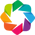

:Layout
   .DynamicMap.I  :DynamicMap   [time]
      :Image   [x0,y0]   (x)
   .DynamicMap.II :DynamicMap   [time]
      :Image   [x0,y0]   (y)

In [10]:
hv.extension('bokeh', 'matplotlib')

grid_style = {'grid_line_color': 'black', 'grid_line_width': 1.5, 'ygrid_bounds': (0.3, 0.7),
              'minor_xgrid_line_color': 'lightgray', 'xgrid_line_dash': [4, 4]}

im_x = (hv.Dataset(ds_particles.x).to(hv.Image, ['x0', 'y0'], name='X', dynamic=True)
                .options(cmap='Magma', width=700, height=350, colorbar=True, tools=['hover'],
                         title='Particle Final Longitude'))

im_y = (hv.Dataset(ds_particles.y).to(hv.Image, ['x0', 'y0'], name='Y', dynamic=True)
                .options(cmap='Magma', width=700, height=350, colorbar=True, tools=['hover'],
                         show_grid=True, gridstyle=grid_style,
                         title='Particle Final Latitude'))

(regrid(im_x, precompute=True) + regrid(im_y, precompute=True)).cols(1)